In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.pipeline import Pipeline as ImbPipeline  
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

df = pd.read_csv("C:/Users/vimba/OneDrive/Documents/School 2025/Spring 2025/ML/ML_Project/raw_database.csv", low_memory=False)
#df.dtypes
#df.head()
#df.dtypes
#df.columns

I Filled the missing categorical variables with 'UNKNOWN' first... it was easier.

In [78]:
#I Filled the missing cat variables with 'UNKNOWN' first... it was easier.
df['Flight Phase'] = df['Flight Phase'].fillna('UNKNOWN')
df['Engine Type'] = df['Engine Type'].fillna('UNKNOWN')
df['State'] = df['State'].fillna('UNKNOWN')
#print(df['Flight Phase'].value_counts(dropna=False))
#print(df['Engine Type'].value_counts(dropna=False))
#print(df['State'].value_counts(dropna=False))

Then I did some mean imputations: 

In [79]:
df['Height'] = pd.to_numeric(df['Height'], errors='coerce') # I did heights next...
df['Height'] = df['Height'].replace(0, np.nan)
df = df[(df['Height'] >= 0) & (df['Height'] <= 10000)]
h_meds = df.groupby('Flight Phase')['Height'].median()
df['Height'] = df['Height'].fillna(df['Flight Phase'].map(h_meds))


df['Speed'] = pd.to_numeric(df['Speed'], errors='coerce') # I did speed afterwards...
df['Speed'] = df['Speed'].replace(0, np.nan)
df = df[(df['Speed'] >= 30) & (df['Speed'] <= 500)]
spd_medians = df.groupby(['Aircraft Type', 'Flight Phase'])['Speed'].median()
df['Speed'] = df.apply(lambda row: spd_medians.get((row['Aircraft Type'], row['Flight Phase']), df['Speed'].median()) 
    if pd.isna(row['Speed']) else row['Speed'], axis=1)


type_med = df.groupby('Aircraft Type')['Aircraft Mass'].median() #I finished up with aircraft mass
df['Aircraft Mass'] = df.apply(lambda row: type_med.get(row['Aircraft Type'], np.nan) 
    if pd.isna(row['Aircraft Mass']) else row['Aircraft Mass'], axis=1)
#Had to do the global mean too, not everything translated through 
g_med = df['Aircraft Mass'].median()
df['Aircraft Mass'] = df['Aircraft Mass'].fillna(g_med)

#df.isna().sum()
#len(df)

So, I changed date to an actual date and seasons; and then did the bucketing on Species Name, Engine Type and Flight Phase. 

In [80]:
#df['Incident Date'] = pd.to_datetime(df[['Incident Year', 'Incident Month', 'Incident Day']].rename(columns={'Incident Year': 'year', 'Incident Month': 'month', 'Incident Day': 'day'}))
#df['Incident Date'] = pd.to_datetime(df['Incident Year'].astype(str) + '-' + df['Incident Month'].astype(str) + '-' + df['Incident Day'].astype(str))
#df['Season'] = df['Incident Month'].map({ 12: 'Winter', 1: 'Winter', 2: 'Winter',3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall'})

#df['Species Name'].value_counts()
#df['Season'].value_counts()
#df['Flight Phase'].value_counts()
#df['Engine Type'].value_counts() <---- I needed to see what the names were.

def b_species(name):
   name = str(name).lower()
   if 'large bird' in name:
        return 'Large Bird'
   elif 'medium bird' in name or 'gull' in name:
        return 'Medium Bird'
   elif 'small bird' in name or any(x in name for x in ['raptor', 'hawk', 'eagle', 'falcon', 'owl']):
        return 'Small Bird'
   else:
        return 'Other'  

df['Species Group'] = df['Species Name'].apply(b_species)

def cl_engine(val):
    val = str(val).strip().upper()
    if val in ['D', 'C', 'A', 'F']:
        return val
    elif val == 'UNKNOWN':
        return 'UNKNOWN'
    else:
        return 'OTHER'

df['Engine Type Cleaned'] = df['Engine Type'].apply(cl_engine)

def cl_phase(val):
    val = str(val).strip().upper()
    if val in ['APPROACH', 'CLIMB', 'EN ROUTE', 'DESCENT']:
        return val
    elif val == 'UNKNOWN':
        return 'UNKNOWN'
    else:
        return 'OTHER'

df['Flight Phase Cleaned'] = df['Flight Phase'].apply(cl_phase)

Now this where I carried out the first model and simplest one: Logistic Reg...

In [81]:
# I removed all the post strike information. The focus is on the target variable
# and the flight phase, post-strike information is irrelevant to us:
y = df['Species Group']
X = df[['Incident Month', 'Flight Phase Cleaned','Aircraft Mass', 'Engine Type Cleaned', 'State', 'Height', 'Speed']]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [83]:
cat_feats = ['Flight Phase Cleaned', 'Engine Type Cleaned', 'State']
nu_feats = ['Aircraft Mass', 'Height', 'Speed', 'Incident Month']

preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats), 
                                               ('num', StandardScaler(), nu_feats)])

In [84]:
logpline = Pipeline([('preprocessing', preprocessor), 
                     ('clf', LogisticRegression(max_iter = 1000, multi_class = 'multinomial', class_weight='balanced'))])
log_param_grid = {'clf__C': [0.5, 1, 10], 'clf__penalty': ['l2'], 'clf__solver': ['saga']}

gr = GridSearchCV(logpline, log_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gr.fit(X_train, y_train)

c:\Users\vimba\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Flight '
                                                                          'Phase '
                                                                          'Cleaned',
                                                                          'Engine '
                                                                          'Type '
                                                                          'Cleaned',
                                                                          'State']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Aircraft '
                                                                          'Mass',
                                                                          'Height',
                                                                          'Speed',
                                                                          'Incident '
                                                                          'Month'])])),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.5, 1, 10], 'clf__penalty': ['l2'],
                         'clf__solver': ['saga']},
             scoring='accuracy')

Time to evaluate the whole thing: 

1. Now looking at ROC and AUC curve: 

In [85]:
best_model = gr.best_estimator_
macro_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

print(f"Macro-Averaged AUC Score: {macro_auc:.2f}. \n \nThis suggests that the model is performing okay but possibly struggling with differentiating between classes.")

Macro-Averaged AUC Score: 0.63. 
 
This suggests that the model is performing okay but possibly struggling with differentiating between classes.


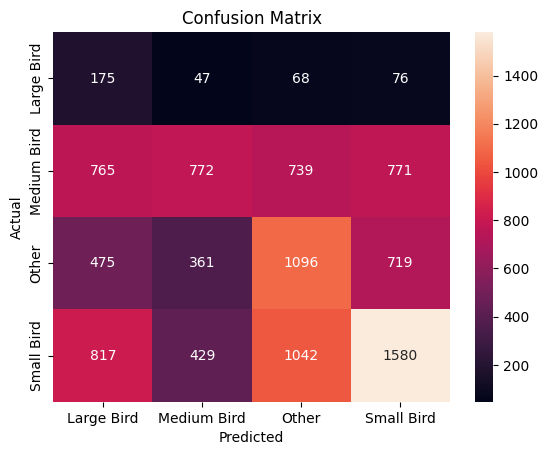

In [106]:
y_pred = gr.predict(X_test)  

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Next was the SVC model... It did better but was not that great of a model.

In [91]:
svc_pline = Pipeline([('preprocessing', preprocessor),('clf', SVC(kernel='linear',class_weight='balanced'))])
svc_par = {'clf__C': [0.1, 1, 5, 10], 'clf__kernel': ['linear'], 'clf__gamma': ['scale', 0.1]}

svc_gr = GridSearchCV(svc_pline, svc_par, cv=3, scoring='accuracy', n_jobs=-1)
svc_gr.fit(X_train, y_train) 

print("Best Model Parametsers:", svc_gr.best_params_)
print("Test Accuracy:", svc_gr.score(X_test, y_test))

Best Model Parametsers: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Test Accuracy: 0.3618606524365687


Things left to do: I need to do feautre importance and apply that. 
and work on 

In [92]:
y_pred = svc_gr.predict(X_test)
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Classification Report:
               precision    recall  f1-score   support

  Large Bird       0.07      0.42      0.12       366
 Medium Bird       0.48      0.23      0.31      3047
       Other       0.36      0.38      0.37      2651
  Small Bird       0.49      0.45      0.47      3868

    accuracy                           0.36      9932
   macro avg       0.35      0.37      0.32      9932
weighted avg       0.44      0.36      0.38      9932



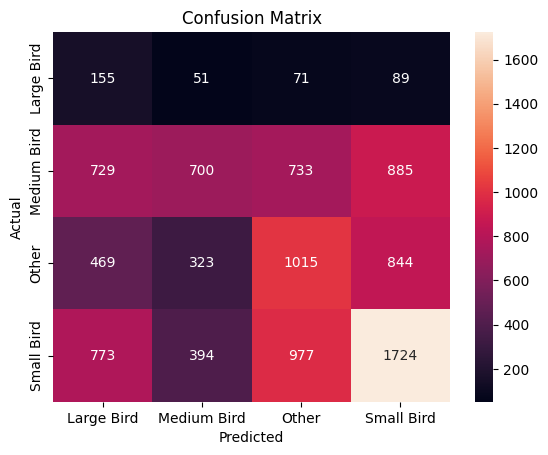

In [107]:
topsvc_model = svc_gr.best_estimator_
y_pred = topsvc_model.predict(X_test)  

cm1 = confusion_matrix(y_test, y_pred)

#disp = ConfusionMatrixDisplay(confusion_matrix = cm1)
#disp.plot(cmap='Blues')
#plt.title("Confusion Matrix for SVC Model Performance")
#plt.show()

sns.heatmap(cm1, annot=True, fmt='d', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

I need 